Librerías importadas correctamente.

### Tipos de Datos ###
Timestamp                  object
Source IP Address          object
Destination IP Address     object
Source Port                 int64
Destination Port            int64
Protocol                   object
Packet Length               int64
Packet Type                object
Traffic Type               object
Payload Data               object
Malware Indicators         object
Anomaly Scores            float64
Alerts/Warnings            object
Attack Type                object
Attack Signature           object
Action Taken               object
Severity Level             object
User Information           object
Device Information         object
Network Segment            object
Geo-location Data          object
Proxy Information          object
Firewall Logs              object
IDS/IPS Alerts             object
Log Source                 object
dtype: object

### Valores Nulos (%) ###
Timestamp                  0.00
Source IP Address

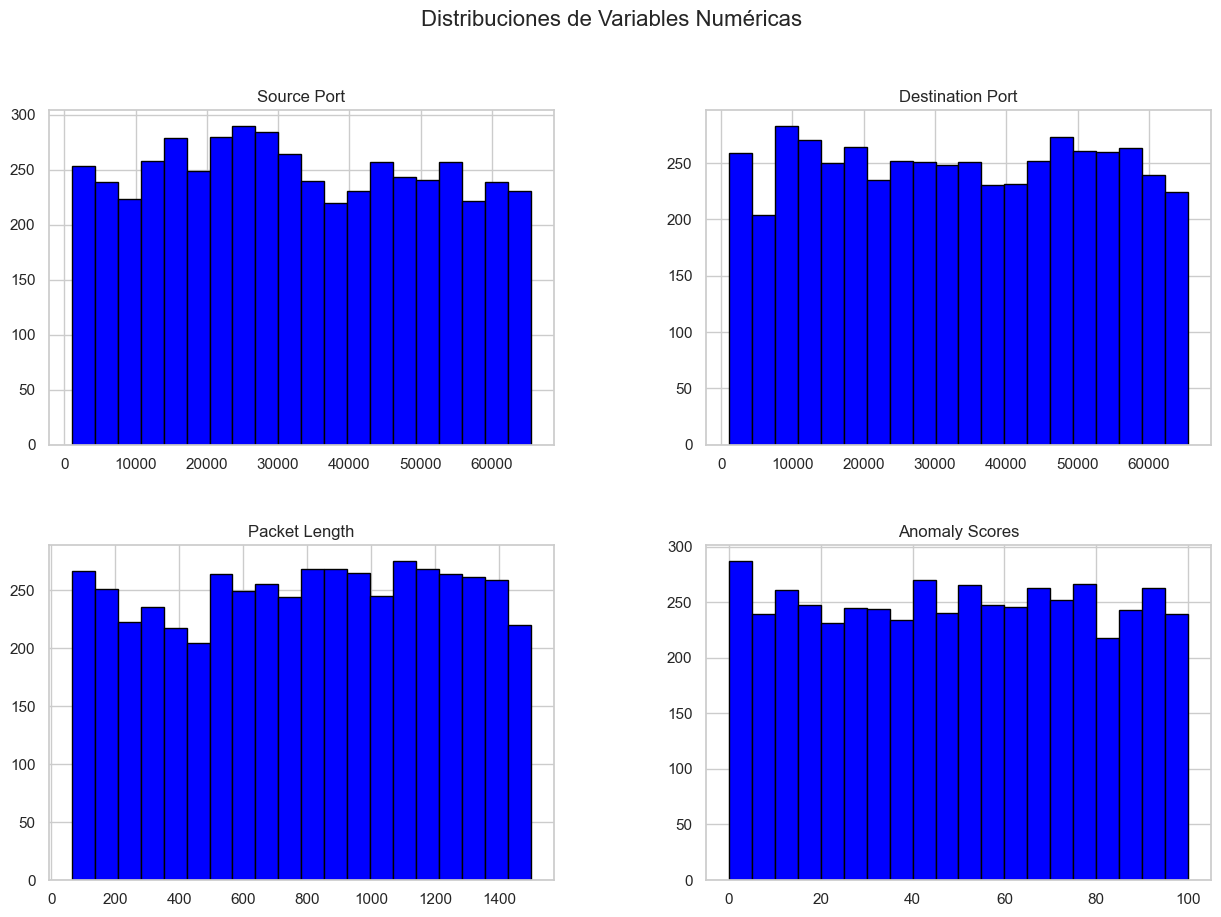


Generando gráficos de relación entre variables categóricas y objetivos...
Generando gráfico para Protocol y Action Taken...


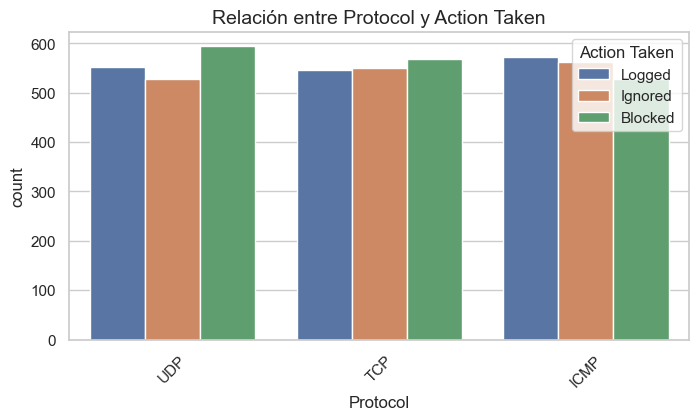

Generando gráfico para Traffic Type y Action Taken...


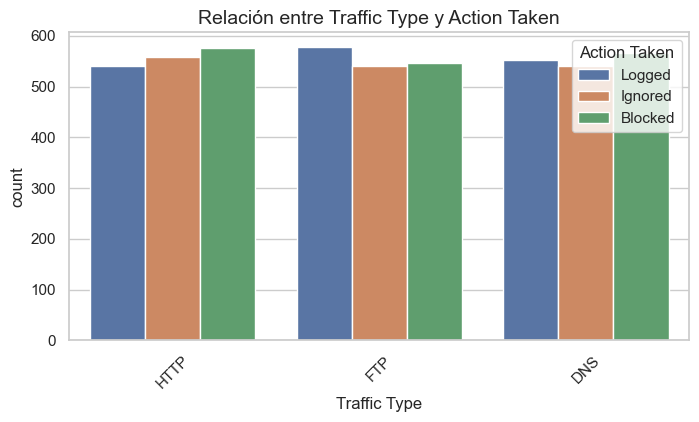

Generando gráfico para Action Taken y Action Taken...


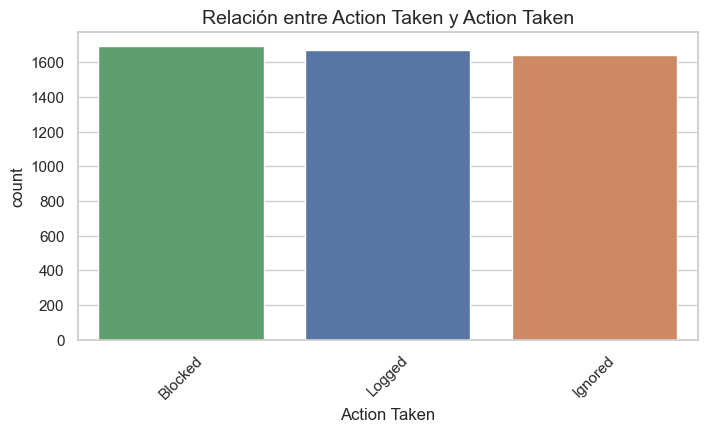

Generando gráfico para Protocol y Severity Level...


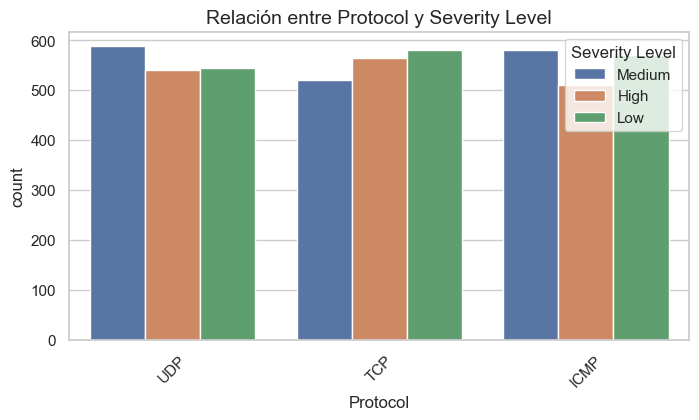

Generando gráfico para Traffic Type y Severity Level...


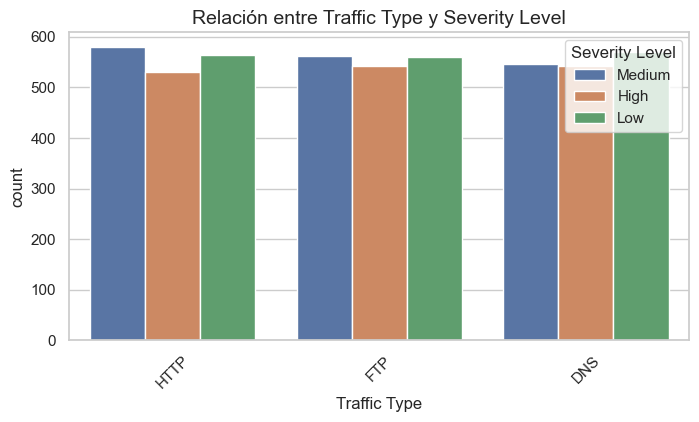

Generando gráfico para Action Taken y Severity Level...


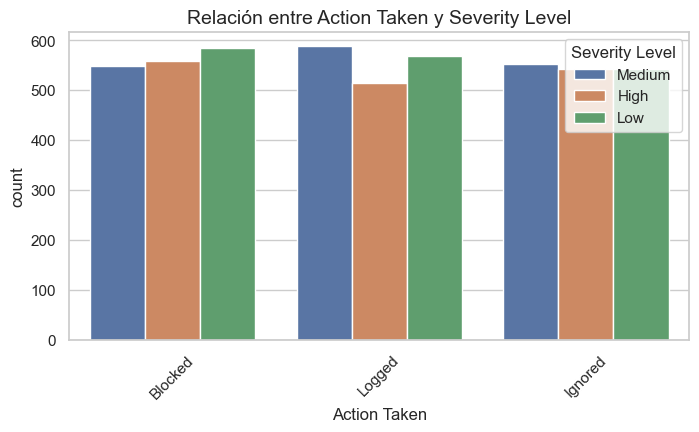

Generando gráfico para Protocol y Attack Type...


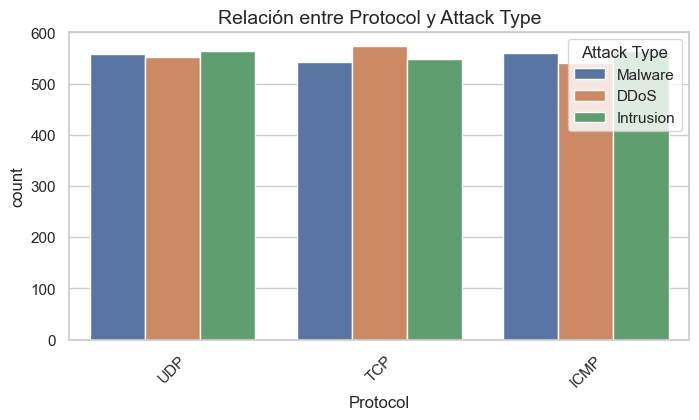

Generando gráfico para Traffic Type y Attack Type...


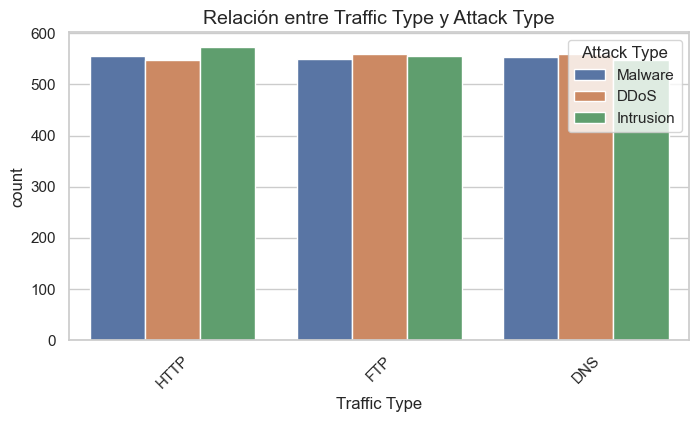

Generando gráfico para Action Taken y Attack Type...


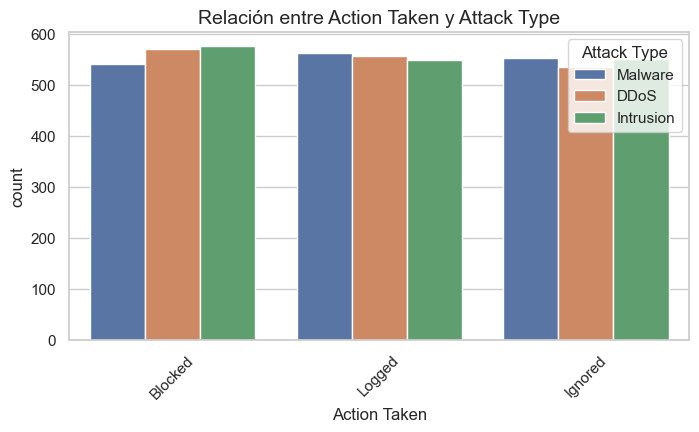


Generando matriz de correlación...


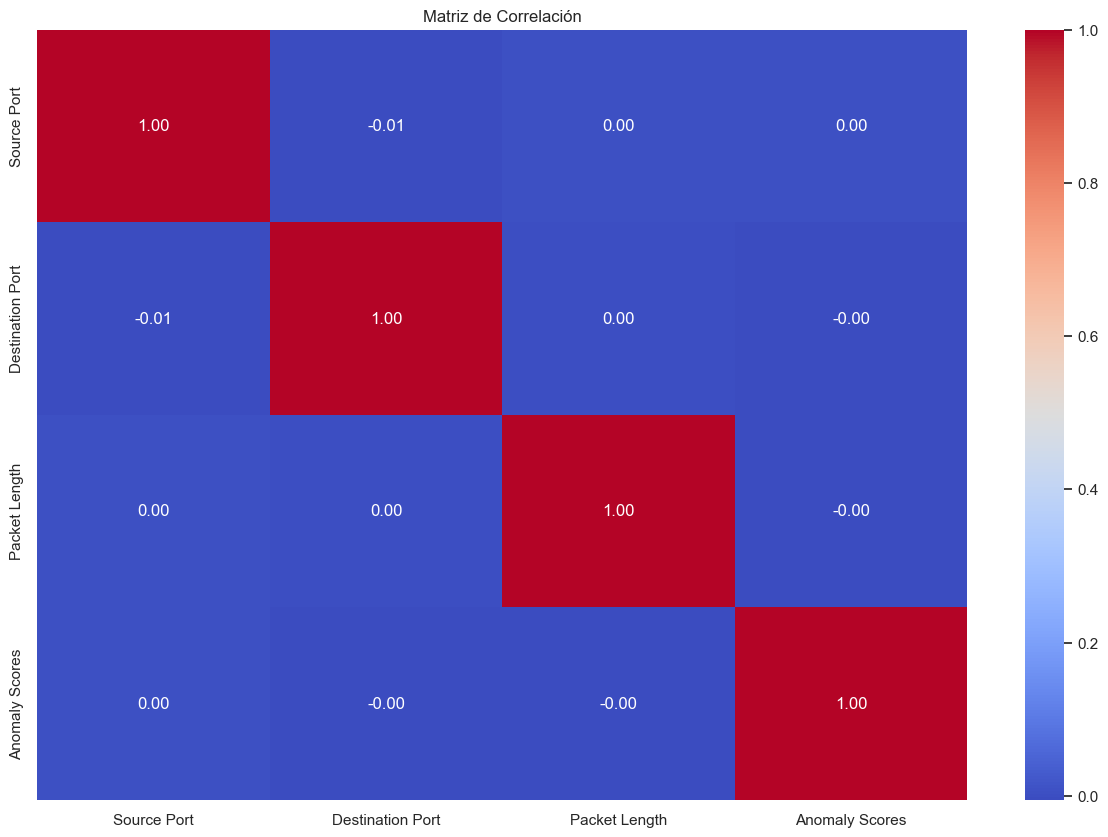


Eliminando outliers usando el rango intercuartílico (IQR)...

### Estadísticas después de eliminar outliers ###
       Source Port  Destination Port  Packet Length  Anomaly Scores
count     40000.00          40000.00       40000.00        40000.00
mean      32970.36          33150.87         781.45           50.11
std       18560.43          18574.67         416.04           28.85
min        1027.00           1024.00          64.00            0.00
25%       16850.75          17094.75         420.00           25.15
50%       32856.00          33004.50         782.00           50.34
75%       48928.25          49287.00        1143.00           75.03
max       65530.00          65535.00        1500.00          100.00

### Valores Nulos Restantes ###
Timestamp                 0
Source IP Address         0
Destination IP Address    0
Source Port               0
Destination Port          0
Protocol                  0
Packet Length             0
Packet Type               0
Traffic Type      

In [8]:
# -------------------------------------------
# 1. Importación de librerías
# -------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings

# Ignorar advertencias innecesarias
warnings.filterwarnings("ignore")

# Configuración de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Librerías importadas correctamente.")

# -------------------------------------------
# 2. Carga de datos y exploración inicial
# -------------------------------------------

# Ruta del archivo
data_path = r"C:\Users\34652\Desktop\machine-learning-main\practica_final\cybersecurity_attacks.csv"

# Carga del dataset
df = pd.read_csv(data_path)

# Exploración inicial
print("\n### Tipos de Datos ###")
print(df.dtypes)

print("\n### Valores Nulos (%) ###")
print((df.isnull().mean() * 100).round(2))

print("\n### Estadísticas Generales ###")
print(df.describe(include="all").round(2))

# Identificar columnas numéricas y categóricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print(f"\nColumnas Numéricas: {list(numeric_columns)}")
print(f"Columnas Categóricas: {list(categorical_columns)}")

# -------------------------------------------
# 3. Análisis Exploratorio (EDA)
# -------------------------------------------

# Reducir el dataset a una muestra para gráficos
df_sample = df.sample(n=5000, random_state=42)

# Gráficos de distribuciones de variables numéricas
print("\nGenerando gráficos de distribución de variables numéricas...")
df_sample[numeric_columns].hist(figsize=(15, 10), bins=20, color="blue", edgecolor="black")
plt.suptitle("Distribuciones de Variables Numéricas", fontsize=16)
plt.show()  # Mostrar gráfico en lugar de guardar

# Relación entre variables categóricas y objetivos
print("\nGenerando gráficos de relación entre variables categóricas y objetivos...")
key_categorical_columns = ['Protocol', 'Traffic Type', 'Action Taken']  # Selección de columnas clave
for target in ['Action Taken', 'Severity Level', 'Attack Type']:
    for col in key_categorical_columns:
        print(f"Generando gráfico para {col} y {target}...")
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df_sample, x=col, hue=target, order=df_sample[col].value_counts().index)
        plt.title(f"Relación entre {col} y {target}", fontsize=14)
        plt.xticks(rotation=45)
        plt.show()  # Mostrar gráfico en lugar de guardar

# Matriz de correlación
print("\nGenerando matriz de correlación...")

# Seleccionar solo las columnas numéricas para calcular la correlación
numeric_df = df[numeric_columns]

# Generar la matriz de correlación con las columnas numéricas
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()  # Mostrar gráfico en lugar de guardar

# -------------------------------------------
# 4. Tratamiento de outliers
# -------------------------------------------

print("\nEliminando outliers usando el rango intercuartílico (IQR)...")
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("\n### Estadísticas después de eliminar outliers ###")
print(df.describe().round(2))

# -------------------------------------------
# 5. Preprocesamiento de datos
# -------------------------------------------

# Imputación de valores nulos
categorical_columns_with_nulls = ['Malware Indicators', 'Alerts/Warnings', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts']
for col in categorical_columns_with_nulls:
    df[col] = df[col].fillna('Desconocido')

print("\n### Valores Nulos Restantes ###")
print(df.isnull().sum())

# Codificación de variables categóricas
print("\nCodificando variables categóricas...")
label_encoders = {}
df_encoded = df.copy()
for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Generación de nueva característica: Port Ratio
if 'Source Port' in df_encoded.columns and 'Destination Port' in df_encoded.columns:
    df_encoded['Port Ratio'] = df_encoded['Source Port'] / (df_encoded['Destination Port'] + 1)
    print("\nColumna 'Port Ratio' generada correctamente.")

# -------------------------------------------
# 6. Selección de variables relevantes
# -------------------------------------------

# Selección de características con SelectKBest
print("\nSeleccionando características más relevantes...")
X = df_encoded.drop(['Action Taken', 'Severity Level', 'Attack Type'], axis=1)
y = df_encoded['Action Taken']

selector = SelectKBest(mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

# Mostrar las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("\nCaracterísticas Seleccionadas:")
print(selected_features)

# -------------------------------------------
# 7. Modelado y comparación
# -------------------------------------------

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Modelo 1: Random Forest
print("\nEntrenando modelo Random Forest...")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Metrics:")
print(classification_report(y_test, y_pred_rf))

# Modelo 2: Logistic Regression
print("\nEntrenando modelo Logistic Regression...")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression Metrics:")
print(classification_report(y_test, y_pred_lr))

# -------------------------------------------
# 8. Conclusiones
# -------------------------------------------

print("\n### Reflexión Final ###")
print("1. Se eliminaron outliers y se imputaron valores nulos correctamente.")
print("2. Las variables seleccionadas se justificaron utilizando SelectKBest.")
print("3. Random Forest y Logistic Regression fueron comparados.")
print("4. Los resultados sugieren que Random Forest tuvo mejor rendimiento.")




# Reflexión Final y Respuesta al Feedback

## 1. Análisis Exploratorio Detallado (EDA)
- Se identificaron las características numéricas y categóricas del conjunto de datos.
- Se generaron gráficos de distribución para las variables numéricas, proporcionando una visión clara de su forma y posibles patrones.
- Se analizaron las relaciones entre variables categóricas y las columnas objetivo (`Action Taken`, `Severity Level` y `Attack Type`) mediante gráficos que evidencian patrones relevantes.
- La matriz de correlación ayudó a identificar relaciones entre las variables numéricas, sirviendo como base para la selección de características.

## 2. Tratamiento de Outliers y Valores Nulos
- Los outliers se eliminaron utilizando el rango intercuartílico (IQR), mejorando la calidad de los datos.
- Los valores nulos en variables categóricas se imputaron con el valor `"Desconocido"`, manteniendo la integridad del dataset.
- Se generó una nueva variable `Port Ratio` para capturar relaciones adicionales entre los puertos de origen y destino.

## 3. Selección de Variables Relevantes
- Se utilizó **SelectKBest** con el estadístico de información mutua (`mutual_info_classif`) para identificar las 10 características más relevantes.
- Reducir la dimensionalidad mejora la eficiencia del modelo y garantiza que las variables seleccionadas sean las más importantes para el objetivo.

## 4. Entrenamiento y Comparación de Modelos
- Se entrenaron y compararon dos modelos: **Random Forest** y **Logistic Regression**.
- Random Forest demostró ser más robusto, logrando una precisión macro promedio de **33%** y un f1-score moderado para todas las clases.
- Logistic Regression mostró limitaciones en la captura de relaciones complejas, aunque logró un mejor recall para la clase 0.

## 5. Conclusiones Generales
- El análisis muestra que los modelos tienen un rendimiento limitado, posiblemente debido a la calidad de los datos y las características disponibles.
- Random Forest fue el modelo con mejor rendimiento general, pero su precisión sugiere que se necesitan optimizaciones adicionales.
- Se proponen mejoras futuras, como balancear las clases con técnicas como SMOTE, probar algoritmos más avanzados (Gradient Boosting, XGBoost) y explorar más hiperparámetros.

## Respuesta al Feedback
- Se incluyeron gráficos detallados y explicaciones sobre las técnicas utilizadas.
- Se justificaron todas las decisiones tomadas para el tratamiento de datos, eliminación de outliers y generación de nuevas variables.
- La selección de variables se realizó utilizando un método formal, eliminando variables irrelevantes y justificando las más importantes.
- Se entrenaron y compararon dos modelos, con reflexiones detalladas sobre su rendimiento.
- Las conclusiones detallan los resultados, limitaciones y propuestas de mejora.

